In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import csv
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import io
from urllib.request import urlopen, Request
from PIL import Image

## Code pour afficher les clusters sur un fond de carte

In [2]:
# Fonction pour récupérer une image coreespondant à une carte
# Code sur https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

## Chargement des données

In [3]:
data = pd.read_csv("uber-raw-data-apr14.csv")

In [39]:
data.head()

,Date/Time,Lat,Lon,Base,Day
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,Mardi
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,Mardi
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,Mardi
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,Mardi
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,Mardi


In [4]:
data.shape

(564516, 4)

In [10]:
base = pd.read_csv("base_codes.csv")

In [11]:
base.head(8)

,Base Code,Base Name
0,B02512,Unter
1,B02598,Hinter
2,B02617,Weiter
3,B02682,Schmecken
4,B02764,Danach-NY
5,B02765,Grun
6,B02835,Dreist
7,B02836,Drinnen


## Visualisation des données

### Visualisation des données en fonction de la longitude et la lattitude 

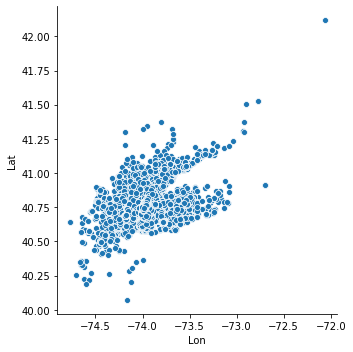

In [179]:
sns.relplot(x='Lon', y='Lat', data=data)

### Visualisation des données catégorielles

In [13]:
data_base = pd.merge(left=data, right=base, left_on='Base', right_on='Base Code')

In [14]:
data_base.drop(["Base Code"], inplace=True, axis=1)

In [15]:
data_base.head()

,Date/Time,Lat,Lon,Base,Base Name
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,Unter
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,Unter
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,Unter
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,Unter
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,Unter


In [16]:
tableau = data_base["Base Name"].value_counts()

In [17]:
tableau_df = pd.DataFrame(tableau)

In [18]:
tableau_df

,Base Name
Schmecken,227808
Hinter,183263
Weiter,108001
Unter,35536
Danach-NY,9908


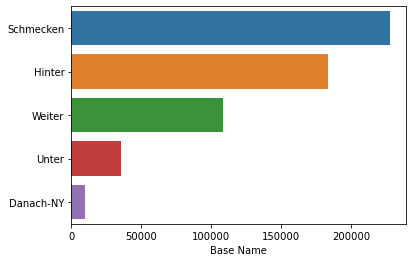

In [19]:
sns.barplot(x='Base Name', y=tableau_df.index, data=tableau_df)

In [20]:
data_base["Date/Time"] = pd.to_datetime(data_base["Date/Time"], infer_datetime_format=True)

In [85]:
data["Hour"] = data_base["Date/Time"].dt.hour

In [87]:
tableau = data["Hour"].value_counts()


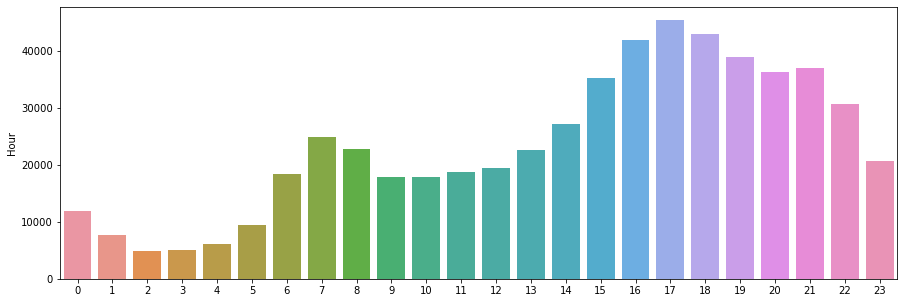

In [91]:
tableau_df = pd.DataFrame(tableau)
plt.figure(figsize=(15,5))
sns.barplot(x=tableau_df.index, y='Hour', data=tableau_df)

In [21]:
data["Day"] = data_base["Date/Time"].dt.dayofweek.apply(lambda x: 'Lundi' if x==0
                                         else 'Mardi' if x==1
                                         else 'Mercredi' if x==2
                                         else 'Jeudi' if x==3
                                         else 'Vendredi' if x==4
                                         else'Samedi' if x==5
                                         else 'Dimanche')

In [22]:
data["Day"]

0            Mardi
1            Mardi
2            Mardi
3            Mardi
4            Mardi
            ...   
564511    Mercredi
564512    Mercredi
564513    Mercredi
564514    Mercredi
564515    Mercredi
Name: Day, Length: 564516, dtype: object

In [23]:
tableau = data["Day"].value_counts()

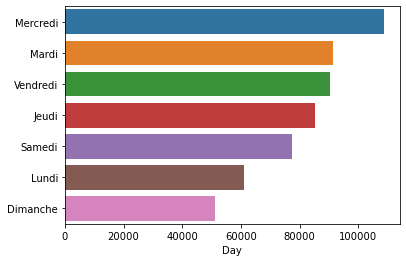

In [25]:
tableau_df = pd.DataFrame(tableau)
sns.barplot(x='Day', y=tableau_df.index, data=tableau_df)

### Affichages des densités de probabilité par longitude et latitude

In [59]:
data.iloc[:1000,1]

In [81]:
dat_NY = data.where((data['Lat']<40.8) & (data['Lat']>40.7) & (data['Lon']<-73.85) & (data['Lon']>-74.0))

In [82]:
dat_NY.dropna(inplace=True)

In [83]:
dat_NY.head()

,Date/Time,Lat,Lon,Base,Day
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,Mardi
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,Mardi
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,Mardi
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,Mardi
6,4/1/2014 0:39:00,40.7223,-73.9887,B02512,Mardi


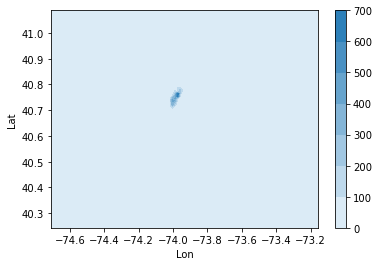

In [180]:
sns.kdeplot(data=data.iloc[:20000,2], data2=data.iloc[:20000,1], shade=True, n_levels=7, cbar=True)

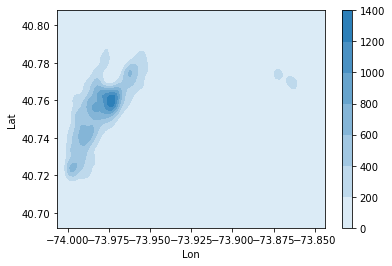

In [181]:
sns.kdeplot(data=dat_NY.iloc[:20000,2], data2=dat_NY.iloc[:20000,1], shade=True, n_levels=7, cbar=True)

## Construction des clusters par minibatchs

In [238]:
from sklearn.cluster import MiniBatchKMeans

In [239]:
X = data.loc[:,['Lat','Lon']]

In [240]:
kmeans = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=1000, max_iter=10).fit(X)

In [241]:
kmeans.cluster_centers_

array([[ 40.7022691 , -74.19682078],
       [ 40.76805363, -73.96590742],
       [ 40.67947228, -73.77719106],
       [ 40.72318787, -73.99225239]])

In [242]:
X_predict = kmeans.predict(X)

In [243]:
X_predict

array([1, 3, 3, ..., 3, 3, 3])

In [244]:
df = pd.DataFrame()
df['predict'] = X_predict

In [245]:
Z = pd.merge(X, df, left_index=True, right_index=True)

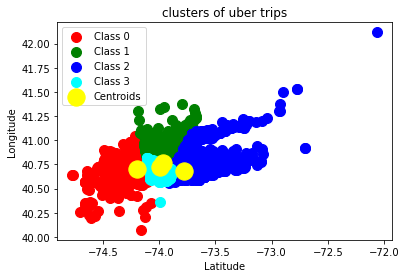

In [259]:
plt.scatter(Z.iloc[:, 1][X_predict == 0], Z.iloc[:, 0][X_predict == 0],  s = 100, c = 'red', label = 'Class 0')
plt.scatter(Z.iloc[:, 1][X_predict == 1], Z.iloc[:, 0][X_predict == 1], s = 100, c = 'green', label = 'Class 1')
plt.scatter(Z.iloc[:, 1][X_predict == 2], Z.iloc[:, 0][X_predict == 2],s = 100, c = 'blue', label = 'Class 2')
plt.scatter(Z.iloc[:, 1][X_predict == 3], Z.iloc[:, 0][X_predict == 3],  s = 100, c = 'cyan', label = 'Class 3')
#plt.scatter(X.iloc[:, 1][y_kmeans == 4], X.iloc[:, 2][y_kmeans == 4], s = 100, c = 'magenta', label = 'Class 4')
#plt.scatter(X.iloc[:, 1][y_kmeans == 5], X.iloc[:, 2][y_kmeans == 5], s = 100, c = 'black', label = 'Class 5')
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], s = 300, c = 'yellow', label = 'Centroids')
plt.title('clusters of uber trips')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

In [247]:
# Préparation des données pour affichage sur le fond de carte
data1_1 = Z.iloc[:, 0][X_predict == 0]
data1_1 = pd.DataFrame(data1_1)
data1_2 = Z.iloc[:, 1][X_predict == 0]
data1_2 = pd.DataFrame(data1_2)

In [248]:
data1 = pd.merge(data1_1, data1_2, left_index=True, right_index=True)

In [275]:
data4.shape

(311660, 2)

In [249]:
data2_1 = Z.iloc[:, 0][X_predict == 1]
data2_1 = pd.DataFrame(data2_1)
data2_2 = Z.iloc[:, 1][X_predict == 1]
data2_2 = pd.DataFrame(data2_2)

In [250]:
data2 = pd.merge(data2_1, data2_2, left_index=True, right_index=True)

In [251]:
data3_1 = Z.iloc[:, 0][X_predict == 2]
data3_1 = pd.DataFrame(data3_1)
data3_2 = Z.iloc[:, 1][X_predict == 2]
data3_2 = pd.DataFrame(data3_2)

In [252]:
data3 = pd.merge(data3_1, data3_2, left_index=True, right_index=True)

In [271]:
data4_1 = Z.iloc[:, 0][X_predict == 3]
data4_1 = pd.DataFrame(data4_1)
data4_2 = Z.iloc[:, 1][X_predict == 3]
data4_2 = pd.DataFrame(data4_2)

In [272]:
data4 = pd.merge(data4_1, data4_2, left_index=True, right_index=True)

## Affichage des clusters sur la carte

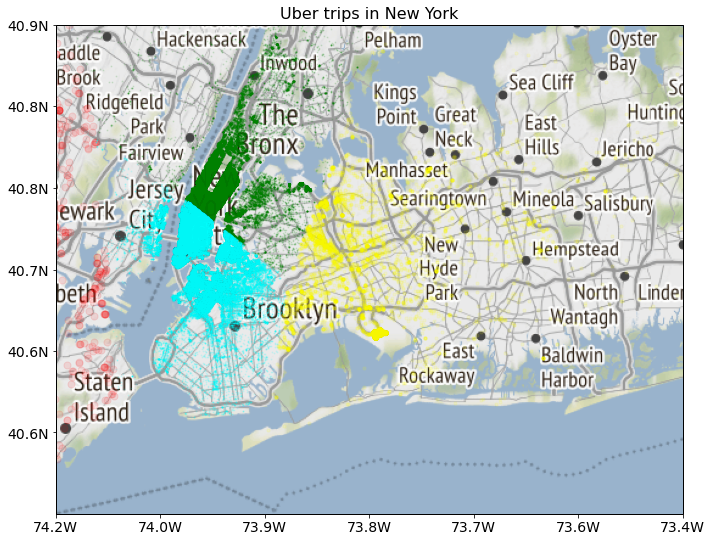

In [276]:
# Code pour afficher une carte et les données
# Code sur https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy

#######################################
# Formatting the Cartopy plot
#######################################
#
cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.Stamen('terrain') # spoofed, downloaded street map

fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
ax1.set_title('Uber trips in New York',fontsize=16)
# extent = [-124.7844079,-66.9513812, 24.7433195, 49.3457868] # Contiguous US bounds
#extent = [-74.257159,-73.699215,40.495992,40.915568] # NYC bounds
extent = [-74.15,-73.44,40.49,40.91] # NYC bounds
ax1.set_extent(extent) # set extents
ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
#ax1.scatter("Lon","Lat", data=data, s=1, transform=ccrs.PlateCarree(), alpha=.1)
ax1.scatter("Lon","Lat", data=data1, s = 50, c = 'red', label = 'Class 0', transform=ccrs.PlateCarree(), alpha=.1)
ax1.scatter("Lon","Lat", data=data2, s = 1, c = 'green', label = 'Class 1', transform=ccrs.PlateCarree(), alpha=.1)
ax1.scatter("Lon","Lat", data=data3, s = 10, c = 'yellow', label = 'Class 2', transform=ccrs.PlateCarree(), alpha=.1)
ax1.scatter("Lon","Lat", data=data4, s = 1, c = 'cyan', label = 'Class 3', transform=ccrs.PlateCarree(), alpha=.1)